<a href="https://colab.research.google.com/github/Madrinmarison/Deep_Learning/blob/main/Transfer_Learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fine-tuning
In the previous notebook we covered transfer learning feature extraction, now it's time to learn a new kind of transfer learning: fine-tuning

In [ ]:
# check if we are using GPU
!nvidia-smi

Wed Sep  7 11:43:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In previous notebook, we've craeted a bunch of helper functions, now we could re-write them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of functions we've used previously [here](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py).

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-07 11:43:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-07 11:43:14 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we are going to use in this notbook
from helper_functions import create_tensorboard_callback, unzip_data, walk_through_dir, plot_loss_curves

> 🔑 **Note:** If you're learning this notebook in Google Colab, when it times out, colab will delete the `helper_function.py`, so you'll have to redownload it if you want an access to the helper functions.

## Let's get some data

This time we are going to see how we can use the pretrained model within `tf.keras.applications` and apply them to our own problem (reconganizig image of food).

--> link: [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [ ]:
# Get 10 % of the training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-09-07 11:43:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   163MB/s    in 1.0s    

2022-09-07 11:43:17 (163 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
# check how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [ ]:
# Create training and test directories paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Load the training and test data
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                      image_size = IMG_SIZE,
                                                      label_mode = "categorical",
                                                      batch_size = BATCH_SIZE)
test_data =  tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                 image_size = IMG_SIZE,
                                                                 label_mode = "categorical",
                                                                 batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# check the classes in our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# see example of a batch of data
for images, lables in train_data_10_percent.take(1):
  print(images, lables)

tf.Tensor(
[[[[2.34239792e+02 2.22239792e+02 1.72698990e+02]
   [2.22341843e+02 2.10744904e+02 1.63622452e+02]
   [2.32933670e+02 2.21989792e+02 1.79627548e+02]
   ...
   [6.42857194e-01 6.86428604e+01 8.92142715e+01]
   [4.59071621e-02 6.77142715e+01 8.67142715e+01]
   [0.00000000e+00 6.66428604e+01 8.56428604e+01]]

  [[2.31755112e+02 2.15301010e+02 1.68234695e+02]
   [2.16515320e+02 2.00596939e+02 1.51948975e+02]
   [2.12693878e+02 1.95979599e+02 1.50107147e+02]
   ...
   [4.28588867e-01 7.07857056e+01 9.09693832e+01]
   [1.07141113e+00 6.90714111e+01 8.82040329e+01]
   [0.00000000e+00 6.80000000e+01 8.70000000e+01]]

  [[2.12923462e+02 1.95923462e+02 1.43066330e+02]
   [2.10270401e+02 1.90413269e+02 1.36214294e+02]
   [1.99673462e+02 1.76979599e+02 1.21571426e+02]
   ...
   [4.59202640e-02 7.12142868e+01 9.28775406e+01]
   [1.53023954e-02 7.02856979e+01 9.07142715e+01]
   [0.00000000e+00 6.84285736e+01 8.92142868e+01]]

  ...

  [[1.74800995e+02 1.76714310e+02 1.61137833e+02]
   [1

## Model 0: Building a transfer learning feature extraction model using keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the Funcitional API gives us more flexibility with our models.

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

# 2 Freeze the base model (so the undelined pre-trained patterns are not updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for Efficientnet(s))
#x = tf.keras.layers.experiemntal.preprocessing.Rescaling(1. / 255.)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs to the base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce the number of computions)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pulling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape} ")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax",  name = "output_layer")(x)

# 8. Cmbine inputs and outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                 experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs to the base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280) 
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220907-114326
Epoch 1/5
24/24 [==============================] - 22s 228ms/step - loss: 1.8290 - accuracy: 0.4280 - val_loss: 1.3065 - val_accuracy: 0.7039
Epoch 2/5
24/24 [==============================] - 5s 185ms/step - loss: 1.1217 - accuracy: 0.7507 - val_loss: 0.9279 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - 5s 183ms/step - loss: 0.8236 - accuracy: 0.8120 - val_loss: 0.7388 - val_accuracy: 0.8010
Epoch 4/5
24/24 [==============================] - 5s 183ms/step - loss: 0.6705 - accuracy: 0.8520 - val_loss: 0.6293 - val_accuracy: 0.8405
Epoch 5/5
24/24 [==============================] - 4s 147ms/step - loss: 0.5800 - accuracy: 0.8680 - val_loss: 0.6144 - val_accuracy: 0.8339


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6090 - accuracy: 0.8420


[0.6090033650398254, 0.8420000076293945]

In [ ]:
# check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# Summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pulling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


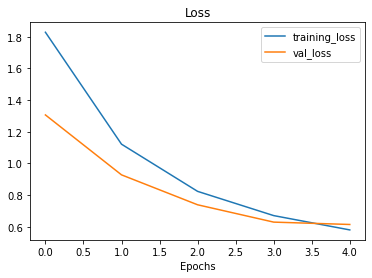

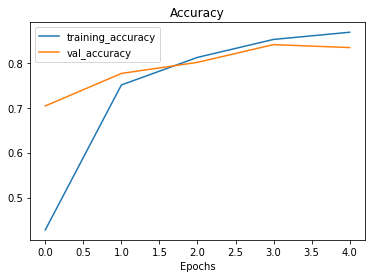

In [ ]:
# check out model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model
Let's demonistrate the Global Average Pooling layer...

We have a tensor after our model goes through through `base_model` of shape (None, 7,7, 1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shape tensor of (1,4,4,3) and then pass it through GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

# Pass the random tensor through a global average 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"\n2D global average pooled random tensor:\n{global_average_pooled_tensor}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]


In [ ]:
# check the shape of different tensor
print(f"Input_shape: {input_tensor.shape}")
print(f"\nGlobal Average Polled 2D tensor shape: {global_average_pooled_tensor.shape}")

Input_shape: (1, 4, 4, 3)

Global Average Polled 2D tensor shape: (1, 3)


In [ ]:
# Ruplicn ate the Global Average Pooling 2D layer.
print(tf.reduce_mean(input_tensor, axis = [1,2]))

tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)


🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens in pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling()` layer) which can then be used to extract patterns out of our own specific problem.

In [ ]:
base_model=tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "Input_Layer")
x = base_model(inputs) # returns a matrix
x = tf.keras.layers.GlobalAveragePooling2D()(x) # returns feature vector
outputs = tf.keras.layers.Dense(10, activation = "softmax")(x) # pass the feature vector here
model_1 = tf.keras.Model(inputs, outputs) # create model of inputs and outputs

# compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
# fit the model
history_10_1 = model_1.fit(train_data_10_percent,
                           epochs = 5,
                           steps_per_epoch = len(train_data_10_percent),
                           validation_data = test_data,
                           validation_steps = int(.25*len(test_data)))


Epoch 1/5
24/24 [==============================] - 10s 202ms/step - loss: 1.8815 - accuracy: 0.4413 - val_loss: 1.3403 - val_accuracy: 0.7138
Epoch 2/5
24/24 [==============================] - 4s 151ms/step - loss: 1.1188 - accuracy: 0.7707 - val_loss: 0.8837 - val_accuracy: 0.8158
Epoch 3/5
24/24 [==============================] - 4s 149ms/step - loss: 0.8210 - accuracy: 0.8200 - val_loss: 0.7636 - val_accuracy: 0.8158
Epoch 4/5
24/24 [==============================] - 4s 148ms/step - loss: 0.6763 - accuracy: 0.8400 - val_loss: 0.6612 - val_accuracy: 0.8339
Epoch 5/5
24/24 [==============================] - 4s 147ms/step - loss: 0.5902 - accuracy: 0.8613 - val_loss: 0.6109 - val_accuracy: 0.8454


## Runing a series of transfer learning experiments

We've seen incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data?

We will set up a bunch of of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data agumentation.
2. `model_2` - Use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning tranfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑 **Note:** throughout all experiments the same dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and Preprocessing data for model 1

In [ ]:
# Download and unzip the data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")


--2022-09-07 11:44:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   157MB/s    in 0.8s    

2022-09-07 11:44:56 (157 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [ ]:
# Inspect how many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

In [ ]:
# Setup data loaders (from directory)
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)# default =32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our model, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation [docmentation](https://www.tensorflow.org/tutorials/images/data_augmentation).

Off the top of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmentating them) happens on the GPU (Much faster rather than CPU).
* Image data augmentation only happens during training, so we can still export our model and use it somewhere.



Creatin data augmention as a layer in our model.

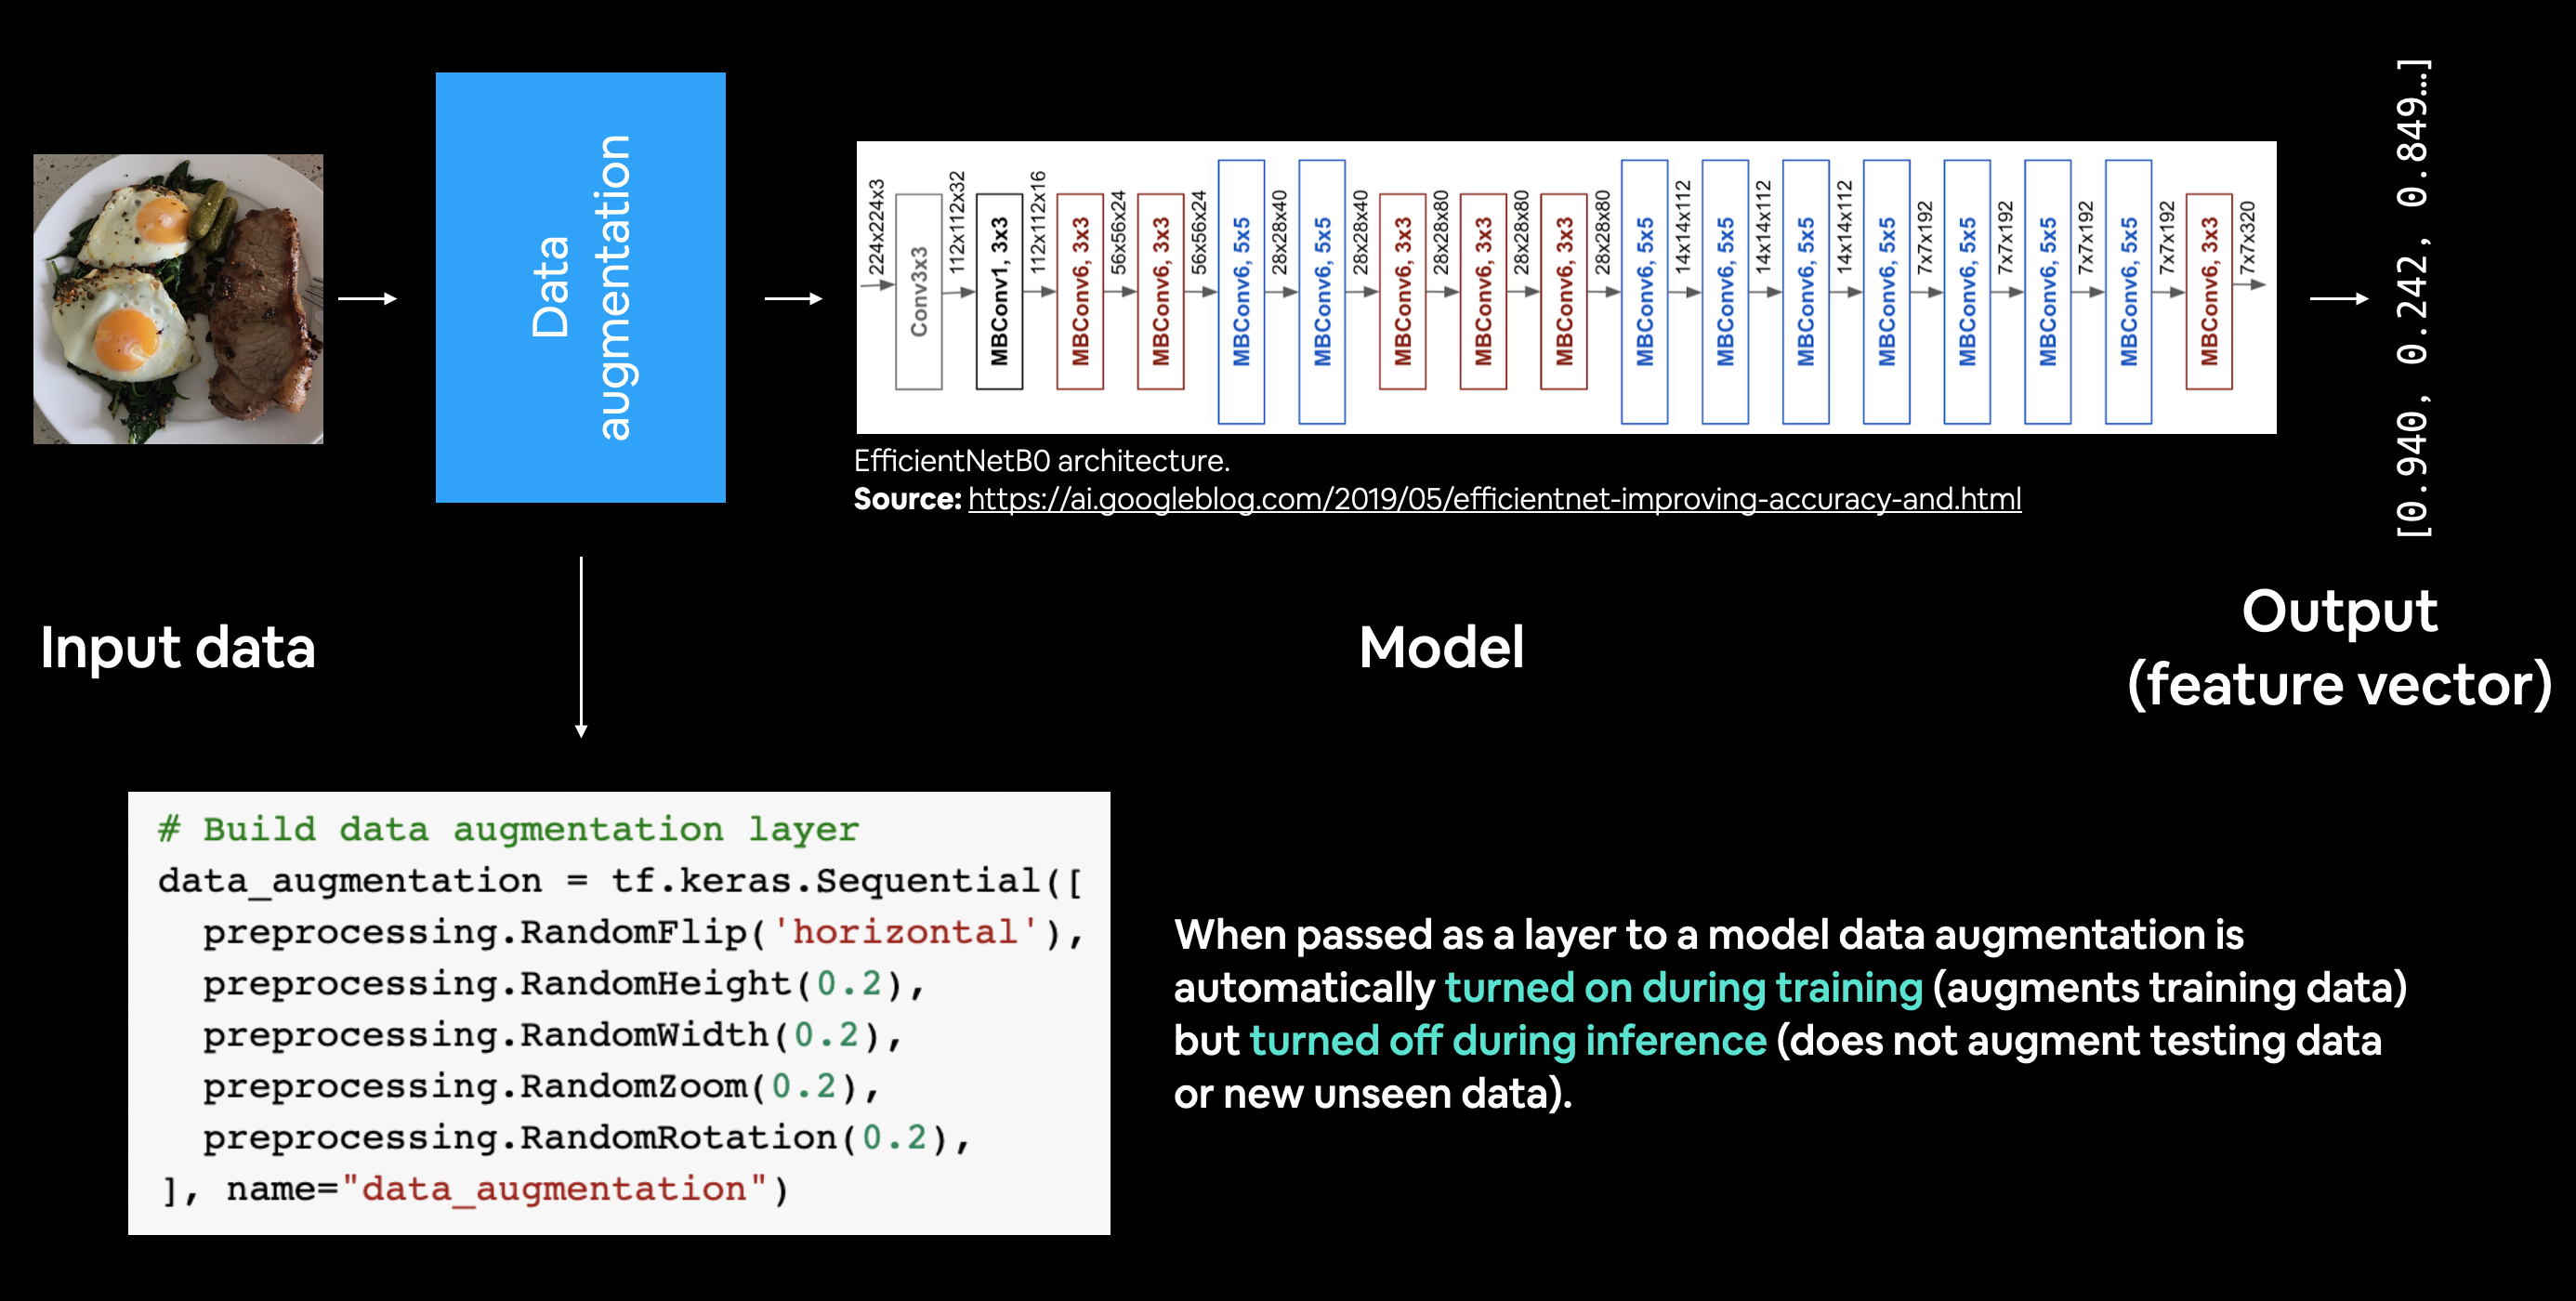

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1/255)# keep for models like ResNet50V2, EfficientNet have rescalling built-in
], name = "data_augmention")

### Visualize data augmention layer (notice what happens to the data)



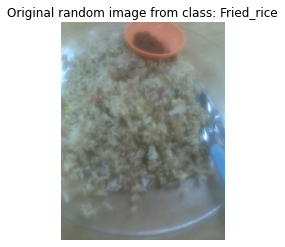

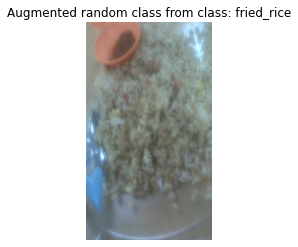

In [ ]:
# View random image and compaire it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
#print(random_image_path)

# Read in a random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class.capitalize()}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0), training =True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random class from class: {target_class.capitalize}")
plt.axis(False);
#print(augmented)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# set up the input shape and base model, freeze the base model layers
input_shape = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False
# Create the input layer
inputs = layers.Input(shape = input_shape, name = "Input_Layer")
# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)
# Give the base_model the inputs (after augmentation) and dont' train it it
x = base_model(x, training = False) # returns a large tensor

# Pool output features of the dense model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Output layer
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)
# make a model using inputs and outputs
model_2 = tf.keras.Model(inputs, outputs)

# compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
# Fit the model
history_1_percent = model_2.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25*len(test_data)),
                                # Track model training logs
                                callbacks =[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                        experiment_name = "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220907-114501
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.3595 - accuracy: 0.0857 - val_loss: 2.2676 - val_accuracy: 0.1513
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0781 - accuracy: 0.2714 - val_loss: 2.1449 - val_accuracy: 0.2319
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9182 - accuracy: 0.3286 - val_loss: 2.0463 - val_accuracy: 0.3174
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8126 - accuracy: 0.5143 - val_loss: 1.9566 - val_accuracy: 0.3799
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5952 - accuracy: 0.6429 - val_loss: 1.8674 - val_accuracy: 0.4490


In [ ]:
# check out our model sumary
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmention (Sequential  (None, None, None, 3)    0         
 )                                                               
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on the full dataset
results_1_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 1.8510 - accuracy: 0.4600


In [ ]:
results_1_percent_data_aug

[1.8510308265686035, 0.46000000834465027]

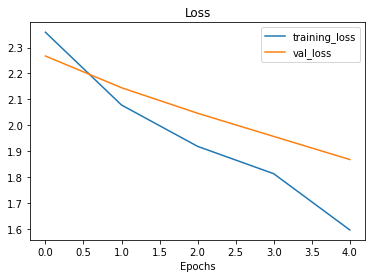

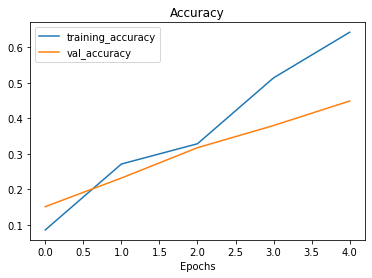

In [ ]:
# How do the model with 1% of the data and data augmentaion loss cuves look?
plot_loss_curves(history_1_percent)

## Model 3: Feature extraction transfer lesarning model with 10% of the data and data augmentation.

In [ ]:
# Get 10% of data... (uncomment if you don't have it)
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data(10_food_classes_10_percent.zip)
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# How many images are in our directories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [ ]:
# create model 3 with data augmentation build in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# BUild data augmentation layer
data_augumentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing .Rescaling(1. / 255)  # 
], name = "data_augumentation")

# Setup the input shape to our model
input_shape = IMG_SIZE + (3,)

# Create a frozen base model (also called the backbone/blueprint)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create inputs and outputs including the layers in between
inputs = layers.Input(shape = input_shape, name = "input_layer")
x = data_augumentation(inputs) # data_augumentation is a model (augment our training images, testing data is not augmented)
x = base_model(x, training = False) # pass the augmented images to the base model but keep it in inference mode, this also ensures that the batchnorm layer does not updat
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Build the model
model_3 = tf.keras.Model(inputs, outputs)

# compile the model
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


In [ ]:
model_3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augumentation (Sequent  (None, 224, 224, 3)      0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback
The ModelCheckPoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come back and start where we left off.

In [ ]:
# Set the checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch", # saves every epoch
                                                         verbose = 1) 

### Fit model 3 passing in the Modelpoint callbacks

In [ ]:

# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_model_3 = model_3.fit(train_data_10_percent,
                        epochs = initial_epochs,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                         experiment_name = "10_percent_data_aug"), 
                                                         checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220907-122637
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9495 - accuracy: 0.3707
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 425ms/step - loss: 1.9495 - accuracy: 0.3707 - val_loss: 1.4658 - val_accuracy: 0.6645
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3262 - accuracy: 0.6760
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 393ms/step - loss: 1.3262 - accuracy: 0.6760 - val_loss: 1.0682 - val_accuracy: 0.7401
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0380 - accuracy: 0.7480
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 332ms/step - loss: 1.0380 - accuracy: 0.7480 - val_loss: 0.8605 - val_accuracy: 0.7895
Ep

In [ ]:
# what is model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6090 - accuracy: 0.8420


[0.6090033054351807, 0.8420000076293945]

In [ ]:
model_3_results = model_3.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6933 - accuracy: 0.8088


In [ ]:
model_3_results

[0.6933354735374451, 0.8087999820709229]

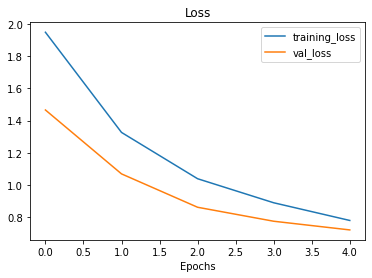

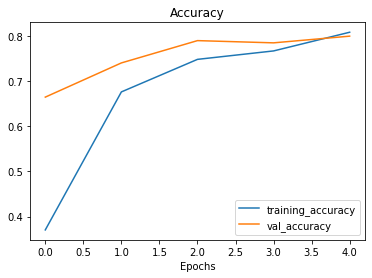

In [ ]:
# plot model loss curves
plot_loss_curves(history_model_3)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [ ]:
# Load in saved model weights and evaluate model
model_3.load_weights(checkpoint_path)

In [ ]:
# Evaluate model 2 with the loaded weights
loaded_weights_model_result = model_3.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.6933 - accuracy: 0.8088


In [ ]:
loaded_weights_model_result

[0.6933354735374451, 0.8087999820709229]

In [ ]:
# If the results from our previously evaluated model_3 match the loaded weights, everything has gone alright!

In [ ]:
model_3_results

[0.6933354735374451, 0.8087999820709229]

In [ ]:
loaded_weights_model_result

[0.6933354735374451, 0.8087999820709229]

In [ ]:
# Check to see if the loaded model results are very close to our previous non-loaded model redults
import numpy as np
np.isclose(np.array(loaded_weights_model_result), np.array(model_3_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(model_3_results) - np.array(loaded_weights_model_result))

[0. 0.]


## Model 3: Fine tunnig of the existing model on 10% of the data.
> 🔑 **Note:** Fine tuning usually works best *after* training a feature extraction model for a few epochs epochs with large amounts of custom data. 

In [ ]:
# Layers in our loaded model
model_3.layers

In [ ]:
# Are this layers trainable?
for layer in model_3.layers:
    print(layer,"    ", layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f24d17b60d0> True
<keras.engine.sequential.Sequential object at 0x7f24d1744510> True
<keras.engine.functional.Functional object at 0x7f24d1263d90> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f24d1aecd50> True
<keras.layers.core.dense.Dense object at 0x7f24d119e290> True


In [ ]:
# what layers are in our base model (EfficientB0)
for i, layer in enumerate(model_3.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# How many trainable variables are our base model?
print(len(model_3.layers[2].trainable_variables))

0


In [ ]:
# To begin fine tunnig, let's start by setting all layers of our base model, trainable = Trues
base_model.trainable = True

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recompile our model every time we make a change)
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001), # when fine tuning you typically want to lower the learning rate by 10x
                metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


🔑 **Note:** When using fine-tuning, it's best practivce to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values). 

A good reource for information on this is the [ULMFiT](https://arxiv.org/abs/1801.06146?LinkSource=PassleApp).

In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_3.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

In [ ]:
# Now we have unfrozen some of layers closer to the top, how many trainable variables are there?
print(len(model_3.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_3 except with more trainable layers)
history_fine_10_percent_data_aug = model_3.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               #steps_per_epochc = len(train_data_10_percent),
                                               validation_data = test_data,
                                               validation_steps = int(.25*len(test_data)),
                                               initial_epoch = history_model_3.epoch[-1],# start training from the previous last epoch
                                               callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                        experiment_name = "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220907-130658
Epoch 5/10
24/24 [==============================] - 18s 474ms/step - loss: 0.6669 - accuracy: 0.8093 - val_loss: 0.5626 - val_accuracy: 0.8141
Epoch 6/10
24/24 [==============================] - 9s 347ms/step - loss: 0.5473 - accuracy: 0.8293 - val_loss: 0.5550 - val_accuracy: 0.8092
Epoch 7/10
24/24 [==============================] - 8s 298ms/step - loss: 0.4644 - accuracy: 0.8627 - val_loss: 0.5261 - val_accuracy: 0.8339
Epoch 8/10
24/24 [==============================] - 8s 321ms/step - loss: 0.4468 - accuracy: 0.8707 - val_loss: 0.5282 - val_accuracy: 0.8109
Epoch 9/10
24/24 [==============================] - 8s 325ms/step - loss: 0.4010 - accuracy: 0.8787 - val_loss: 0.5446 - val_accuracy: 0.8141
Epoch 10/10
24/24 [==============================] - 8s 330ms/step - loss: 0.3568 - accuracy: 0.8973 - val_loss: 0.5162 - val_accuracy: 0.8158


In [ ]:
# Evaluate the fine-tuned model (model_4 which is actually model_3 fine_tuned for another 5 epochs)
result_fine_tune_10_percent = model_3.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.5088 - accuracy: 0.8296


In [ ]:
result_fine_tune_10_percent

[0.5088369846343994, 0.8295999765396118]

In [ ]:
model_3_results

[0.6933354735374451, 0.8087999820709229]

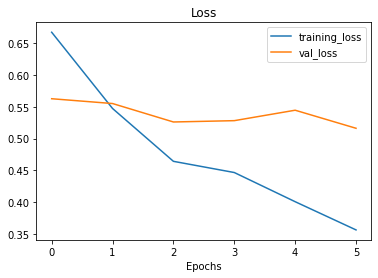

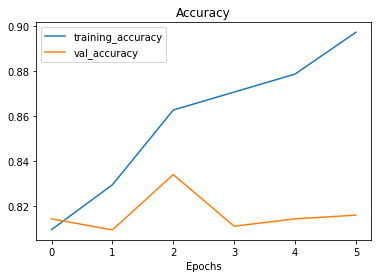

In [ ]:
 # check the loss curves of our fine_tuned model
 plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want somthing to compiare one series of running `fit()` with another (e.g. before and after fine-tuning)

In [ ]:
# Create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs):
    """
    Compaires two TensorFlow History Objects.
    """
    # Get the original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics with new_history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots for accuarcy
    plt.figure(figsize = (8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label = "Training Accuracy")
    plt.plot(total_val_acc, label = "Validation Accuracy")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label = "Start Fine Tuning")
    plt.legend(loc = "lower right")
    plt.title("Training and Validation Accuracy")

        # Make plots for loss
    plt.figure(figsize = (8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss, label = "Training Loss")
    plt.plot(total_val_loss, label = "Validation Loss")
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label = "Start Fine Tuning")
    plt.legend(loc = "upper right")
    plt.title("Training and Validation Loss")


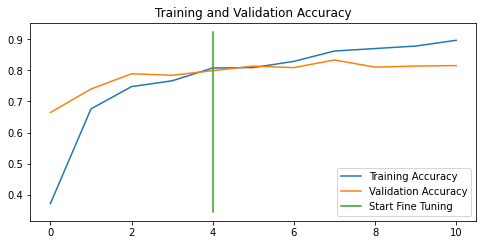

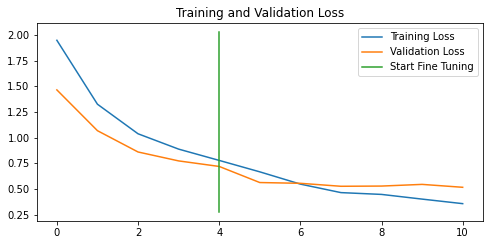

In [ ]:
compare_histories(history_model_3,
                   history_fine_10_percent_data_aug, 5)

## Model 4: Fine-tuning an existing model on all the data.

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-09-07 14:01:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   183MB/s    in 2.7s    

2022-09-07 14:01:08 (183 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Set up training and testing dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 image_size = IMG_SIZE,
                                                                                 label_mode = "categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The dataset we've loaded in is the same as what we've been for previuos experiment (all experiments have used same test dataset)

Let's verify this...

In [ ]:
# Evaluate model 3 (this is the fine-tuned on 10 percent of data version)
model_3.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.5088 - accuracy: 0.8296


[0.5088369846343994, 0.8295999765396118]

In [ ]:
result_fine_tune_10_percent

[0.5088369846343994, 0.8295999765396118]

To train a fine-tuning model (model_4) we need to revert model_3 back to it's feature extraction weight.

In [ ]:
# load weight from the CheckPoint, that way we can fine-tune from 
# the same stage the 10 percent data model was fine-tuned from
model_3.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_3 now
model_3.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6933 - accuracy: 0.8088


[0.6933355331420898, 0.8087999820709229]

In [ ]:
# Check to see if our model_3 has been reverted back to feature extraction results
loaded_weights_model_result

[0.6933354735374451, 0.8087999820709229]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Training a features extraction transfer learning model for 5 epochs on 10% of the data with data augmentaion (model_2) and we saved model weights using `ModelCheckpoint` callback.

2. We fined tuneed the same model on the same 10% of the data for a further 5 epochs with the 10 layers of the base model unfrozen (model_3).

3. Saved the resiults and training logs each time.
4. Reloaded model from step 1 to do the same steps as step 2 except this time we are going to use all of the data (model_4).

In [ ]:
# check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_3.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augumentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_3.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

In [ ]:
# Recompile our model
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                metrics = ["accuracy"])

In [ ]:
# continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_3.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps = int(0.25*len(test_data)),
                                           initial_epoch = history_model_3.epoch[-1],
                                           callbacks = [create_tensorboard_callback(dir_name = "transfer_learning", 
                                                                                   experiment_name = "Full_10_classes_fine_tune_10")])

Saving TensorBoard log files to: transfer_learning/Full_10_classes_fine_tune_10/20220907-153723
Epoch 5/10
235/235 [==============================] - 58s 216ms/step - loss: 0.7316 - accuracy: 0.7659 - val_loss: 0.3979 - val_accuracy: 0.8553
Epoch 6/10
235/235 [==============================] - 47s 198ms/step - loss: 0.5823 - accuracy: 0.8133 - val_loss: 0.3812 - val_accuracy: 0.8684
Epoch 7/10
235/235 [==============================] - 43s 179ms/step - loss: 0.5150 - accuracy: 0.8328 - val_loss: 0.3399 - val_accuracy: 0.8898
Epoch 8/10
235/235 [==============================] - 39s 164ms/step - loss: 0.4745 - accuracy: 0.8443 - val_loss: 0.3594 - val_accuracy: 0.8799
Epoch 9/10
235/235 [==============================] - 38s 160ms/step - loss: 0.4276 - accuracy: 0.8653 - val_loss: 0.3279 - val_accuracy: 0.8865
Epoch 10/10
235/235 [==============================] - 37s 155ms/step - loss: 0.4042 - accuracy: 0.8691 - val_loss: 0.3087 - val_accuracy: 0.9030


In [ ]:
# Evaluate on all of the test data
results_fine_tune_full_data = model_3.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 74ms/step - loss: 0.3155 - accuracy: 0.8956


[0.3154594302177429, 0.8956000208854675]

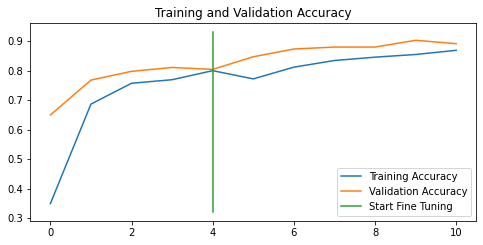

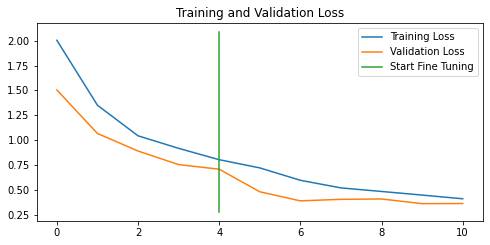

In [ ]:
# How did fine-tuning go with more data
compare_histories(original_history = history_model_3,
                  new_history = history_fine_10_classes_full,
                  initial_epochs = 5)

## Viewing our experiment results on TensorBord
> 🔑 **Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

In [ ]:
# View tensorbord logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --log_dir ./transfer_learning \
     --name "Transfer Learning Experiment with 10 Food101 Classes" \
     -- description "A series of different transfer learning experiments with varying amount of data and fine tuning." \
     --one_shot # exits the uploader once it's finished uploading


usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: unrecognized arguments: -- description A series of different transfer learning experiments with varying amount of data and fine tuning.
